# Cointegration Ratio Among Top Pairs

### Modules

In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [126]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'FTMUSDT', 'GALAUSDT', 'NEARUSDT', 'AVAXUSDT', '1000SHIBUSDT', 'SANDUSDT', 'WAVESUSDT', 'ADAUSDT', 'XRPUSDT', 'RUNEUSDT', 'BNBUSDT', 'ATOMUSDT', 'MATICUSDT', 'DOTUSDT', 'MANAUSDT', 'LINKUSDT', 'KNCUSDT', 'AXSUSDT', 'DOGEUSDT', 'LTCUSDT', 'YFIUSDT', 'YFIIUSDT', 'ZECUSDT', 'XMRUSDT', 'ETCUSDT']
data = {}
prices_1h = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices_1h[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices_1h[asset]['price'] = prices_1h[asset]['price'].apply(lambda x: math.log(x))
    

### Rolling Cointegration Functions

In [111]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue, result.params[0]


def johansen_coint(A, B):
    df = pd.DataFrame({'x': A, 'y': B})
    jres = coint_johansen(df, 0, 1)
    return jres.max_eig_stat[0], jres.max_eig_stat_crit_vals[0], jres.evec[0]


def cointegration(coint_type, confidence_interval, data_A, data_B):
    
    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]
    
    data_A = list(data_A)
    data_B = list(data_B)
    
    
    if coint_type == 'engle-granger':
        pvalue, beta = engle_granger_coint(data_A, data_B)
        cointegrated = pvalue <= 1 - confidence_interval
        return cointegrated, beta

    elif coint_type == 'johansen':
        max_eig_value, max_eig_crit_val, eigenvectors = johansen_coint(data_A, data_B)
        if confidence_interval == 0.9:
            cointegrated = max_eig_value > max_eig_crit_val[0]
        elif confidence_interval == 0.95:
            cointegrated = max_eig_value > max_eig_crit_val[1]
        elif confidence_interval == 0.99:
            cointegrated = max_eig_value > max_eig_crit_val[2]
        else:
            raise Exception('Wrong convidence interval')
        return cointegrated, eigenvectors
    
    else:
        raise Exception('Wrong Cointegration Type')

        
def rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window):
    
    dates = list(data_A['date'])

    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]

    rolling_coint = {'date':[], 'cointegrated': [], 'beta': []}
    
    # Rolling Cointegration
    for i in range(len(dates)-1, 0, -1):
        if i - lookback_window >= 0:
            data_window_A = list(data_A['price'].iloc[i - lookback_window:i])
            data_window_B = list(data_B['price'].iloc[i - lookback_window:i])
            cointegrated, beta = cointegration(coint_type, confidence_interval, data_window_A, data_window_B)
            
            rolling_coint['date'].append(dates[i])
            rolling_coint['cointegrated'].append(cointegrated)
            rolling_coint['beta'].append(beta)

    return rolling_coint


def calculate_consecutive_candles(rolling_cointegration):
    
    candles_counter = 0
    cointegrated = False
    beta = []
    start_date = ''
    end_date = ''
    
    rolling_cointegration = pd.DataFrame(rolling_cointegration)
    consecutive_candles = {'start_date': [], 'end_date': [], 'nbr_of_candles': [], 'beta_median': []}
    
    for i in range(0, len(rolling_cointegration)):
        row = rolling_cointegration.iloc[i]
        if not cointegrated and row['cointegrated']:
            cointegrated = True
            end_date = row['date']
            beta.append(row['beta'])
        elif cointegrated and row['cointegrated']:
            candles_counter += 1
            beta.append(row['beta'])
        elif cointegrated and not row['cointegrated']:
            if candles_counter > 0:
                start_date = row['date']
                beta_median = pd.Series(beta).median()

                consecutive_candles['start_date'].append(start_date)
                consecutive_candles['end_date'].append(end_date)
                consecutive_candles['nbr_of_candles'].append(candles_counter)
                consecutive_candles['beta_median'].append(beta_median) #Careful with this if using johansen
        
            # Reset variables
            candles_counter = 0
            cointegrated = False
            beta = []
            start_date = ''
            end_date = ''
            
        else:
            pass
    
    return consecutive_candles



### Rolling Ratio of Pairs Cointegrated

In [127]:
# Get all possible pairs
counter = 0
selected_assets = assets
coint_type = 'engle-granger'
confidence_interval = 0.95
hist_window = 24 * 30 * 3
lookback_window = 24*10

total_pairs = int((len(selected_assets) * len(selected_assets) - len(selected_assets)) / 2)

pairs = {'pair': [], 'rolling_cointegration': []}

for asset_a in selected_assets:
    for asset_b in selected_assets:
        if asset_a != asset_b and '{}/{}'.format(asset_b, asset_a) not in pairs['pair']:
            counter += 1
            data_A = prices_1h[asset_a][(len(prices_1h[asset_a])-hist_window):]
            data_B = prices_1h[asset_b][(len(prices_1h[asset_b])-hist_window):]
            print("Calculating pair {} of {}".format(counter, total_pairs))
            rolling_coint = rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window)
            pairs['pair'].append('{}/{}'.format(asset_a, asset_b))
            pairs['rolling_cointegration'].append(pd.DataFrame(rolling_coint))



Calculating pair 1 of 28
Calculating pair 2 of 28
Calculating pair 3 of 28
Calculating pair 4 of 28
Calculating pair 5 of 28
Calculating pair 6 of 28
Calculating pair 7 of 28
Calculating pair 8 of 28
Calculating pair 9 of 28
Calculating pair 10 of 28
Calculating pair 11 of 28
Calculating pair 12 of 28
Calculating pair 13 of 28
Calculating pair 14 of 28
Calculating pair 15 of 28
Calculating pair 16 of 28
Calculating pair 17 of 28
Calculating pair 18 of 28
Calculating pair 19 of 28
Calculating pair 20 of 28
Calculating pair 21 of 28
Calculating pair 22 of 28
Calculating pair 23 of 28
Calculating pair 24 of 28
Calculating pair 25 of 28
Calculating pair 26 of 28
Calculating pair 27 of 28
Calculating pair 28 of 28


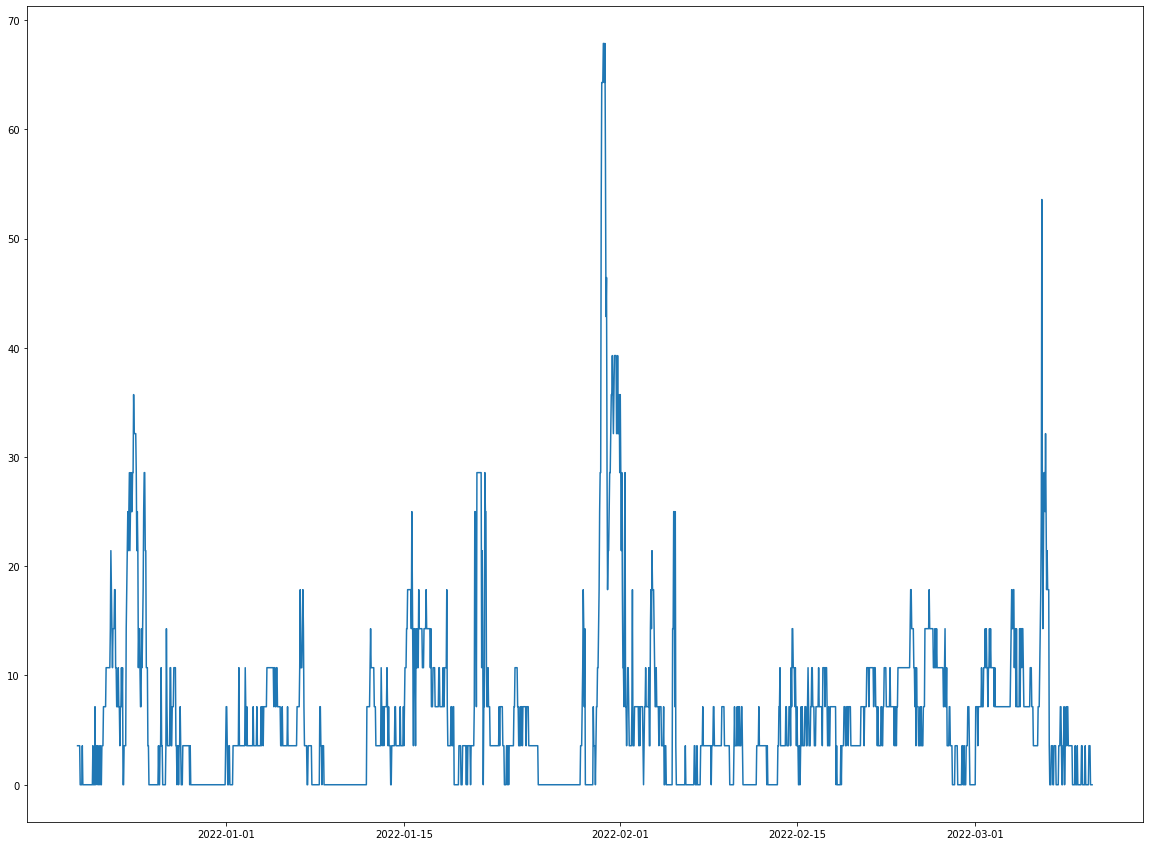

In [128]:
pairs_df = pd.DataFrame(pairs)
dates = pairs_df.iloc[0]['rolling_cointegration']['date']
pairs_coint = pd.DataFrame(index=dates, columns=pairs['pair'])

# Cointegration True/False at a given date
for i in pairs_df.index:
    for date in dates:
        pairs_coint.loc[date][pairs_df.iloc[i]['pair']] = (pairs_df.iloc[i]['rolling_cointegration'][pairs_df.iloc[i]['rolling_cointegration']['date'] == date]['cointegrated']).bool()

# Count % of cointegration at a given date
perct_of_coint = pd.DataFrame({'date': [], 'perct_of_coint': []})
nbr_of_pairs = len(pairs['pair'])

prct_cointegrated = 0
for i in range(0, len(pairs_coint)-1):
    prct_cointegrated = (nbr_of_pairs - np.bincount(list(pairs_coint.iloc[i,:]))[0])/nbr_of_pairs*100
    perct_of_coint = pd.concat([perct_of_coint, pd.DataFrame({'date': [pairs_coint.index[i]], 'perct_of_coint': [prct_cointegrated]})])

plt.figure(figsize=(20,15))
plt.plot(perct_of_coint['date'], perct_of_coint['perct_of_coint'])

(False, 0.9320069913457096)
(False, array([10.16059468,  1.67764018]))


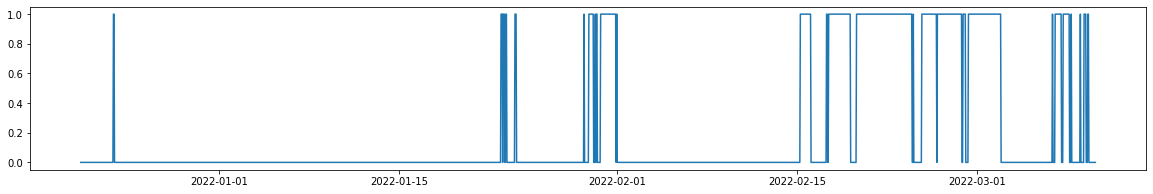

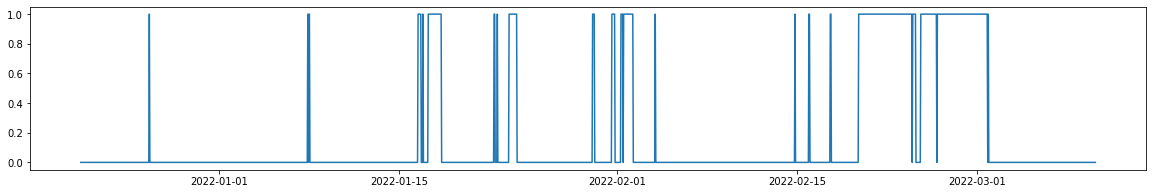

In [129]:
asset_A = 'ZECUSDT'
asset_B = 'XMRUSDT'
hist_window = 24*30*3
lb_window = 24*11
convidence_interval = 0.95
data_A = prices_1h[asset_A][(len(prices_1h[asset_A])-hist_window):]
data_B = prices_1h[asset_B][(len(prices_1h[asset_B])-hist_window):]
print(cointegration('engle-granger', convidence_interval, data_A['price'], data_B['price']))
print(cointegration('johansen', convidence_interval, data_A['price'], data_B['price']))

rolling_coint_eg = rolling_cointegration('engle-granger', convidence_interval, data_A, data_B, lb_window)

plt.figure(figsize=(20,3))
plt.plot(rolling_coint_eg['date'], rolling_coint_eg['cointegrated'])

rolling_coint_jo = rolling_cointegration('johansen', convidence_interval, data_A, data_B, lb_window)
plt.figure(figsize=(20,3))
plt.plot(rolling_coint_jo['date'], rolling_coint_jo['cointegrated'])



In [122]:
_pairs_coint = pairs_coint

In [124]:

_pairs






{'pair': ['BTCUSDT/ETHUSDT',
  'BTCUSDT/LUNAUSDT',
  'BTCUSDT/SOLUSDT',
  'BTCUSDT/FTMUSDT',
  'BTCUSDT/GALAUSDT',
  'BTCUSDT/NEARUSDT',
  'BTCUSDT/AVAXUSDT',
  'BTCUSDT/1000SHIBUSDT',
  'BTCUSDT/SANDUSDT',
  'BTCUSDT/WAVESUSDT',
  'BTCUSDT/ADAUSDT',
  'BTCUSDT/XRPUSDT',
  'BTCUSDT/RUNEUSDT',
  'BTCUSDT/BNBUSDT',
  'BTCUSDT/ATOMUSDT',
  'BTCUSDT/MATICUSDT',
  'BTCUSDT/DOTUSDT',
  'BTCUSDT/MANAUSDT',
  'BTCUSDT/LINKUSDT',
  'BTCUSDT/KNCUSDT',
  'BTCUSDT/AXSUSDT',
  'BTCUSDT/DOGEUSDT',
  'BTCUSDT/LTCUSDT',
  'BTCUSDT/YFIUSDT',
  'BTCUSDT/YFIIUSDT',
  'BTCUSDT/ZECUSDT',
  'BTCUSDT/XMRUSDT',
  'ETHUSDT/LUNAUSDT',
  'ETHUSDT/SOLUSDT',
  'ETHUSDT/FTMUSDT',
  'ETHUSDT/GALAUSDT',
  'ETHUSDT/NEARUSDT',
  'ETHUSDT/AVAXUSDT',
  'ETHUSDT/1000SHIBUSDT',
  'ETHUSDT/SANDUSDT',
  'ETHUSDT/WAVESUSDT',
  'ETHUSDT/ADAUSDT',
  'ETHUSDT/XRPUSDT',
  'ETHUSDT/RUNEUSDT',
  'ETHUSDT/BNBUSDT',
  'ETHUSDT/ATOMUSDT',
  'ETHUSDT/MATICUSDT',
  'ETHUSDT/DOTUSDT',
  'ETHUSDT/MANAUSDT',
  'ETHUSDT/LINKUSDT',
  'ETHUSD